In [1]:
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import BackendEstimator, Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator
from custom_jax_sim import JaxSolver, DynamicsBackendEstimator
import numpy as np
from qiskit_dynamics.array import Array
from qiskit.compiler import schedule as build_schedule
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit.transpiler import InstructionProperties

from qiskit import pulse
from typing import Optional, List, Dict
from qiskit.circuit import Gate
from qiskit.circuit.library import get_standard_gate_name_mapping
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management import (
    FixedFrequencyTransmon,
    EchoedCrossResonance,
)
from qiskit_experiments.library import RoughDragCal, RoughXSXAmplitudeCal
from itertools import permutations


def perform_standard_calibrations(
        backend: DynamicsBackend, calibration_files: Optional[List[str]] = None
):
    """
    Generate baseline single qubit gates (X, SX, RZ, H) for all qubits using traditional calibration experiments
    :param backend: Dynamics Backend on which calibrations should be run
    :param calibration_files: Optional calibration files containing single qubit gate calibrations for provided
        DynamicsBackend instance (Qiskit Experiments does not support this feature yet)

    """

    target, qubits = backend.target, range(backend.num_qubits)
    num_qubits = len(qubits)
    single_qubit_properties = {(qubit,): None for qubit in qubits}
    single_qubit_errors = {(qubit,): 0.0 for qubit in qubits}

    control_channel_map = backend.options.control_channel_map
    physical_control_channel_map = None
    if control_channel_map is not None:
        physical_control_channel_map = {
            (qubit_pair[0], qubit_pair[1]): backend.control_channel(
                (qubit_pair[0], qubit_pair[1])
            )
            for qubit_pair in control_channel_map
        }
    elif num_qubits > 1:
        all_to_all_connectivity = tuple(permutations(qubits, 2))
        control_channel_map = {
            (q[0], q[1]): index for index, q in enumerate(all_to_all_connectivity)
        }
        physical_control_channel_map = {
            (q[0], q[1]): [pulse.ControlChannel(index)]
            for index, q in enumerate(all_to_all_connectivity)
        }
    backend.set_options(control_channel_map=control_channel_map)
    coupling_map = [list(qubit_pair) for qubit_pair in control_channel_map]
    two_qubit_properties = {qubits: None for qubits in control_channel_map}
    two_qubit_errors = {qubits: 0.0 for qubits in control_channel_map}
    standard_gates: Dict[
        str, Gate
    ] = get_standard_gate_name_mapping()  # standard gate library
    fixed_phase_gates, fixed_phases = ["z", "s", "sdg", "t", "tdg"], np.pi * np.array(
        [1, 0.5, -0.5, 0.25, -0.25]
    )
    other_gates = ["rz", "id", "h", "x", "sx", "reset", "delay"]
    single_qubit_gates = fixed_phase_gates + other_gates
    two_qubit_gates = ["ecr"]
    exp_results = {}
    existing_cals = calibration_files is not None

    phi: Parameter = standard_gates["rz"].params[0]
    if existing_cals:
        cals = Calibrations.load(files=calibration_files)
    else:
        cals = Calibrations(
            coupling_map=coupling_map,
            control_channel_map=physical_control_channel_map,
            libraries=[
                FixedFrequencyTransmon(basis_gates=["x", "sx"]),
                EchoedCrossResonance(basis_gates=["cr45p", "cr45m", "ecr"]),
            ],
            backend_name=backend.name,
            backend_version=backend.backend_version,
        )
    if (
            len(target.instruction_schedule_map().instructions) <= 1
    ):  # Check if instructions have already been added
        for gate in single_qubit_gates:
            target.add_instruction(
                standard_gates[gate], properties=single_qubit_properties
            )
        if num_qubits > 1:
            for gate in two_qubit_gates:
                target.add_instruction(
                    standard_gates[gate], properties=two_qubit_properties
                )
            backend._coupling_map = target.build_coupling_map(two_qubit_gates[0])

    for qubit in qubits:  # Add calibrations for each qubit
        control_channels = list(
            filter(
                lambda x: x is not None,
                [control_channel_map.get((i, qubit), None) for i in qubits],
            )
        )
        # Calibration of RZ gate, virtual Z-rotation
        with pulse.build(backend, name=f"rz{qubit}") as rz_cal:
            pulse.shift_phase(-phi, pulse.DriveChannel(qubit))
            for q in control_channels:
                pulse.shift_phase(-phi, pulse.ControlChannel(q))
        # Identity gate
        id_cal = pulse.Schedule(
            pulse.Delay(20, pulse.DriveChannel(qubit))
        )  # Wait 20 cycles for identity gate

        delay_param = standard_gates["delay"].params[0]
        with pulse.build(backend, name=f"delay{qubit}") as delay_cal:
            pulse.delay(delay_param, pulse.DriveChannel(qubit))

        # Update backend Target by adding calibrations for all phase gates (fixed angle virtual Z-rotations)
        target.update_instruction_properties(
            "rz", (qubit,), InstructionProperties(calibration=rz_cal, error=0.0)
        )
        target.update_instruction_properties(
            "id", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        target.update_instruction_properties(
            "reset", (qubit,), InstructionProperties(calibration=id_cal, error=0.0)
        )
        target.update_instruction_properties(
            "delay", (qubit,), InstructionProperties(calibration=delay_cal, error=0.0)
        )
        for phase, gate in zip(fixed_phases, fixed_phase_gates):
            gate_cal = rz_cal.assign_parameters({phi: phase}, inplace=False)
            instruction_prop = InstructionProperties(calibration=gate_cal, error=0.0)
            target.update_instruction_properties(gate, (qubit,), instruction_prop)

        # Perform calibration experiments (Rabi/Drag) for calibrating X and SX gates
        if not existing_cals and backend.options.subsystem_dims[qubit] > 1:
            rabi_exp = RoughXSXAmplitudeCal(
                [qubit], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 100)
            )
            drag_exp = RoughDragCal(
                [qubit], cals, backend=backend, betas=np.linspace(-20, 20, 15)
            )
            drag_exp.set_experiment_options(reps=[3, 5, 7])
            print(f"Starting Rabi experiment for qubit {qubit}...")
            rabi_result = rabi_exp.run().block_for_results()
            print(f"Rabi experiment for qubit {qubit} done.")
            print(f"Starting Drag experiment for qubit {qubit}...")
            drag_result = drag_exp.run().block_for_results()
            print(f"Drag experiments done for qubit {qubit} done.")
            exp_results[qubit] = [rabi_result, drag_result]

        # Build Hadamard gate schedule from following equivalence: H = S @ SX @ S

        # sx_schedule = block_to_schedule(cals.get_schedule("sx", (qubit,)))
        # s_schedule = block_to_schedule(target.get_calibration("s", (qubit,)))
        # h_schedule = pulse.Schedule(s_schedule, sx_schedule, s_schedule, name="h")
        sx_schedule = cals.get_schedule("sx", (qubit,))
        s_schedule = target.get_calibration("s", (qubit,))
        with pulse.build(backend, name="h") as h_schedule:
            pulse.call(s_schedule)
            pulse.call(sx_schedule)
            pulse.call(s_schedule)

        target.update_instruction_properties(
            "h",
            (qubit,),
            properties=InstructionProperties(calibration=h_schedule, error=0.0),
        )

    print("All single qubit calibrations are done")
    # cals.save(file_type="csv", overwrite=True, file_prefix="Custom" + backend.name)
    error_dict = {"x": single_qubit_errors, "sx": single_qubit_errors}
    target.update_from_instruction_schedule_map(
        cals.get_inst_map(), error_dict=error_dict
    )
    # for qubit_pair in control_channel_map:
    #     print(qubit_pair)
    #     cr_ham_exp = CrossResonanceHamiltonian(physical_qubits=qubit_pair, flat_top_widths=np.linspace(0, 5000, 17),
    #                                            backend=backend)
    #     print("Calibrating CR for qubits", qubit_pair, "...")
    #     data_cr = cr_ham_exp.run().block_for_results()
    #     exp_results[qubit_pair] = data_cr

    print("Updated Instruction Schedule Map", target.instruction_schedule_map())

    return cals, exp_results

In [27]:
# define the system
dim = 3

v0, v1 = 4.86e9, 4.97e9
anharm0, anharm1 = -0.32e9, -0.32e9
r0, r1 = 0.22e9, 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim ** 2, dtype=complex)

N0, N1 = np.kron(ident, N), np.kron(N, ident)
a0, a1 = np.kron(ident, a), np.kron(a, ident)
a0dag, a1dag = np.kron(ident, adag), np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
        static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver_2q_jax = JaxSolver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
solver_2q = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
# Consistent solver option to use throughout notebook

solver_options = [
    {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt} for _ in range(2)
]
solver = solver_2q_jax
jax_backend = DynamicsBackend(
    solver=solver_2q_jax,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[0],  # to be used every time run is called
)

standard_backend = DynamicsBackend(
    solver=solver_2q,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options[1],  # to be used every time run is called
)

In [28]:
jax_cals, jax_results = perform_standard_calibrations(backend=jax_backend)
standard_cals, standard_results = perform_standard_calibrations(
    backend=standard_backend
)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'h', 'sx', 'id', 'measure', 'rz', 'sdg', 's', 't', 'x', 'reset', 'tdg', 'z', 'delay'}
  q1: {'h', 'sx', 'id', 'measure', 'rz', 'sdg', 's', 't', 'x', 'reset', 'tdg', 'z', 'delay'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'ecr', 'cr45m'}
  (1, 0): {'cr45p', 'ecr', 'cr45m'}
)>
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done fo

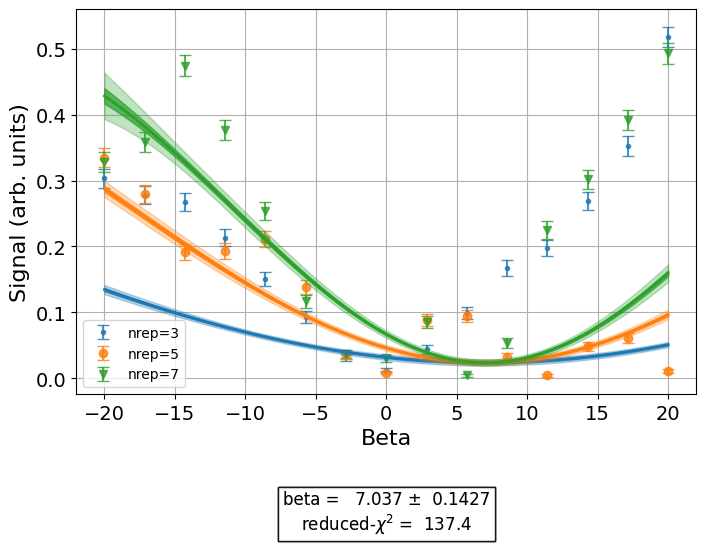

In [29]:
jax_results[0][1].figure(0)

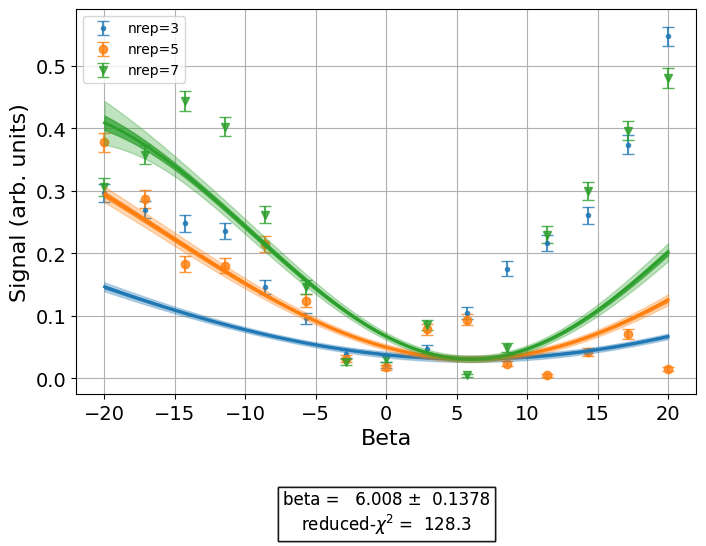

In [30]:
standard_results[0][1].figure(0)

In [31]:
observable = SparsePauliOp.from_list([("YY", 1.0), ("YX", 1.0), ("ZZ", 1.0)])
estimator = BackendEstimator(backend=standard_backend)
aer_backend_estimator = BackendEstimator(backend=AerSimulator())
jax_estimator = DynamicsBackendEstimator(backend=jax_backend)
base_estimator = Estimator()
aer_estimator = AerEstimator()

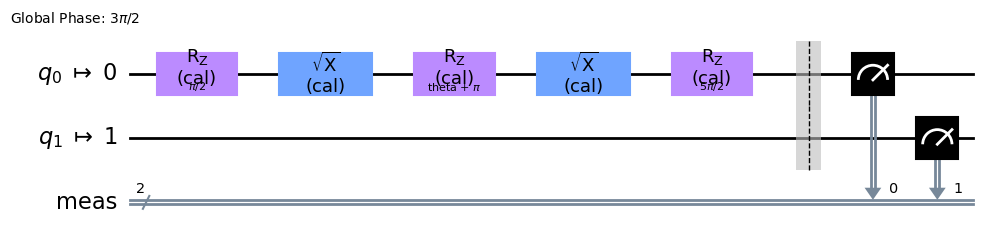

In [52]:
from qiskit import transpile

param = Parameter("theta")
qc = QuantumCircuit(2)
qc.rx(param, 0)
qc.measure_all()
qc = transpile(qc, standard_backend, optimization_level=0)
qc.draw("mpl")

In [55]:
qc2 = qc.assign_parameters({param: np.pi / 2}, inplace=False)
print("DynamicsBackend", standard_backend.run(qc2, shots=2000).result().get_counts())
print("Aer", AerSimulator().run(qc2, shots=2000).result().get_counts())
jax_backend.options.shots = 2000
print("Jax Backend", jax_backend.run(qc2).result().get_counts())

DynamicsBackend {'00': 955, '01': 1045}
Aer {'00': 996, '01': 1004}
Jax Backend {'00': 1040, '01': 960}


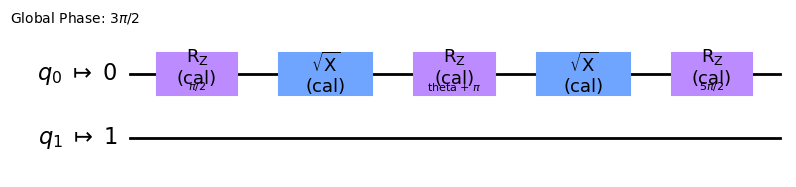

In [56]:
qc.remove_final_measurements(inplace=False).draw("mpl")

In [59]:
print("Expectation value for", observable.paulis)
param_val = np.pi
print(
    "Qiskit",
    base_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
    )
    .result()
    .values,
)
print(
    "Aer",
    aer_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
        shots=5000,
    )
    .result()
    .values,
)
print(
    "BackendEstimator with AerSimulator",
    aer_backend_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
        shots=5000,
    )
    .result()
    .values,
)
print(
    "BackendEstimator with DynamicsBackend",
    estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
        shots=5000,
    )
    .result()
    .values,
)


def get_schedule(qc, backend):
    def macro():
        return build_schedule(qc, backend)

    return macro


solver_2q_jax.circuit_macro = get_schedule(qc, jax_backend)
print(
    "Jax Backend",
    jax_estimator.run(
        qc.remove_final_measurements(inplace=False),
        observable,
        parameter_values=param_val,
    )
    .result()
    .values,
)

Expectation value for ['YY', 'YX', 'ZZ']
Qiskit [-1.]
Aer [-0.9912]
BackendEstimator with AerSimulator [-0.9876]
BackendEstimator with DynamicsBackend [-1.0292]
Jax Backend [-1.058]


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


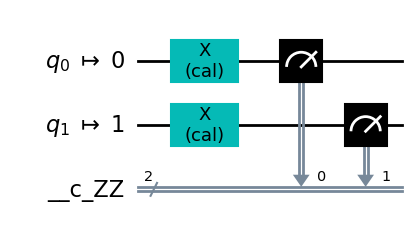

In [12]:
estimator.transpiled_circuits[2].draw("mpl")

In [13]:
duration = build_schedule(estimator.transpiled_circuits[1], standard_backend).duration
standard_backend.solve([estimator.transpiled_circuits[1]], t_span=[0, duration * dt])

[ t: [ 0.000e+00  7.133e-08]
  y: [Statevector([-9.99999979e-01+0.j,  0.00000000e+00+0.j,
                   0.00000000e+00+0.j,  2.03458787e-04+0.j],
                 dims=(2, 2)), Statevector([ 0.0035606 +0.57137441j, -0.01531791-0.41492425j,
                  -0.57336   +0.00191961j,  0.41528861+0.00172309j],
                 dims=(2, 2))]]

In [14]:
solver_2q_jax.stored_results

[Statevector([-0.49261217+0.08114218j,  0.49426177+0.07518057j,
               0.49382686-0.07666877j, -0.49448234-0.08128368j],
             dims=(2, 2)),
 Statevector([-0.07829813-0.49098281j, -0.07834241+0.4913205j ,
               0.07951282+0.49545622j,  0.07812184-0.4974236j ],
             dims=(2, 2)),
 Statevector([ 4.97056833e-04-0.00081485j, -5.28825325e-03+0.00071763j,
              -1.57137606e-01+0.00115254j,  9.87591601e-01-0.00067335j],
             dims=(2, 2))]

In [15]:
solver_2q_jax.batched_sims

Array([[[-9.99999979e-01+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  2.03458787e-04+0.j        ],
        [ 4.97056833e-04-0.00081485j, -5.28825325e-03+0.00071763j,
         -1.57137606e-01+0.00115254j,  9.87591601e-01-0.00067335j]]],      dtype=complex128)

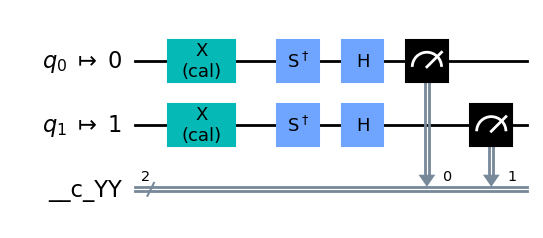

In [16]:
jax_estimator.transpiled_circuits[0].draw("mpl")

In [17]:
from custom_jax_sim.jax_solver import PauliToQuditOperator
from qiskit.circuit.library import HGate

np.round(
    PauliToQuditOperator([Operator(HGate()), Operator(HGate())], [3, 3]).to_matrix(), 3
)

array([[ 0.5  +0.j,  0.5  +0.j,  0.   +0.j,  0.5  +0.j,  0.5  +0.j,
         0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.5  +0.j, -0.5  +0.j,  0.   +0.j,  0.5  +0.j, -0.5  +0.j,
         0.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.707+0.j,  0.   +0.j,  0.   +0.j,
         0.707+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.5  +0.j,  0.5  +0.j,  0.   +0.j, -0.5  +0.j, -0.5  +0.j,
        -0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.5  +0.j, -0.5  +0.j,  0.   +0.j, -0.5  +0.j,  0.5  -0.j,
        -0.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.707+0.j, -0.   +0.j, -0.   +0.j,
        -0.707+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
         0.   +0.j,  0.707+0.j,  0.707+0.j,  0.   +0.j],
       [ 0.   +0.j, -0.   +0.j,  0.   +0.j,  0.   +0.j, -0.   +0.j,
         0.   +0.j,  0.707+0.j, -0.707+0.j,  0.   +0.j],


In [18]:
Operator(HGate()) ^ Operator(HGate()).to_matrix()

Operator([[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
          [ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j],
          [ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
          [ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5-0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [19]:
op = Operator.from_label("IX")
qc = QuantumCircuit(2)
qc.x(0)
print(op)
print(Statevector.from_label("00").evolve(Operator(qc)))
print(Statevector.from_label("00").evolve(op))

Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [20]:
op2 = Operator.from_label("I") ^ Operator.from_label("X")
op2

Operator([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


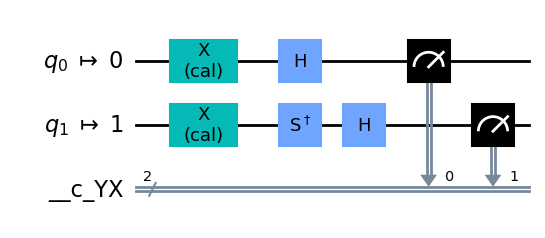

In [21]:
jax_estimator.circuits_to_be_sent[1].draw("mpl")

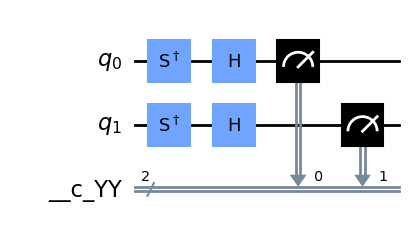

In [22]:
jax_estimator.preprocessed_circuits[0][1][0].draw("mpl")

In [23]:
solver_2q_jax.observables

[Operator([[ 0.49999998+0.j        ,  0.        -0.49999998j,
             0.        -0.49999998j, -0.49999998-0.j        ],
           [ 0.49999998+0.j        ,  0.        +0.49999998j,
             0.        -0.49999998j,  0.49999998+0.j        ],
           [ 0.49999998+0.j        ,  0.        -0.49999998j,
             0.        +0.49999998j,  0.49999998+0.j        ],
           [ 0.49999998+0.j        ,  0.        +0.49999998j,
             0.        +0.49999998j, -0.49999998+0.j        ]],
          input_dims=(2, 2), output_dims=(2, 2)),
 Operator([[ 0.49999998+0.j        ,  0.        -0.49999998j,
             0.49999998+0.j        ,  0.        -0.49999998j],
           [ 0.49999998+0.j        ,  0.        +0.49999998j,
             0.49999998+0.j        ,  0.        +0.49999998j],
           [ 0.49999998+0.j        ,  0.        -0.49999998j,
            -0.49999998+0.j        ,  0.        +0.49999998j],
           [ 0.49999998+0.j        ,  0.        +0.49999998j,
            

In [24]:
solver_2q_jax.stored_results[1].evolve(solver_2q_jax.observables[1])

Statevector([-0.00244421+0.00234699j,  0.00365889+0.00212642j,
              0.41546656-0.41498738j, -0.57327751-0.57145162j],
            dims=(2, 2))


In [60]:
jax_estimator.backend